# Concept Drift

In this noetbook, we work with synthetic data in a concept drift setting. Concretely, we have two labeling concepts $c_1$ and $c_2$ and we choose which concept to use with a propability $p_t$ that evolves with time. We can formulate the labeling concept at time $t$ as $c = X_tc_1 + \left( 1 - X_t\right)c_2$

Where $X_t \sim Bernoulli\left( p_t\right)$ and $p_t = \frac{e^{-\left(t - t_0\right)/\tau}}{1 + e^{-\left(t - t_0\right)/\tau}}$; $t_0$ controls when the shift from $c_1$ to $c_2$ practically starts while $\tau$ controls the rate of this shift.

In [1]:
from env import *
from agent import *
import matplotlib.pyplot as plt
import re
import tensorboard as tb
from skmultiflow.trees import HoeffdingTreeClassifier
from skmultiflow.evaluation import EvaluatePrequential
from skmultiflow.data.base_stream import Stream
from skmultiflow.utils import check_random_state
%matplotlib inline

iteration = lambda s : int(re.split('_', s[:-4])[-1])

In [2]:
categories = [3, 5, 3, 3, 3, 5, 3, 5, 3, 3, 4, 3, 3, 3, 5]
d = len(categories)
labels = [0, 1]
actions = range(d + len(labels))

# Feature variables are independent and uniform
generator = dict([(i, np.full(categories[i], 1/categories[i])) for i in range(len(categories))])

# Each query action costs -1
rewards_queries = dict([(i, -.5) for i in range(len(categories))])

# Define the one-hot encoder.
encoder = Encoder(categories=categories)

## DQN

Let's define the environment and the DQN agent.

In [3]:
env = EnvironmentDrift(generator, rewards_queries, encoder=encoder, r_plus=5, r_minus=-5, split_1=4, split_2=3)
agent = DQN(categories=categories)

Run training with a prequential evaluation of the model for which we save the data in a tensorboard event.

In [4]:
agent.train(env, n_episodes=100000, n_pretrain=512, n_learn=5, max_tau=50, decay_rate=2e-6, lr=5e-4, batch_size=256, 
            log_dir='runs_drift_dqn/', path_save='drift_dqn/', prequential=True)

Episode : 0, epsilon : 1.000
Episode : 1000, epsilon : 0.970
Episode : 2000, epsilon : 0.942
Episode : 3000, epsilon : 0.914
Episode : 4000, epsilon : 0.887
Episode : 5000, epsilon : 0.861
Episode : 6000, epsilon : 0.835
Episode : 7000, epsilon : 0.811
Episode : 8000, epsilon : 0.787
Episode : 9000, epsilon : 0.763
Episode : 10000, epsilon : 0.741
Episode : 11000, epsilon : 0.719
Episode : 12000, epsilon : 0.698
Episode : 13000, epsilon : 0.677
Episode : 14000, epsilon : 0.657
Episode : 15000, epsilon : 0.638
Episode : 16000, epsilon : 0.619
Episode : 17000, epsilon : 0.601
Episode : 18000, epsilon : 0.583
Episode : 19000, epsilon : 0.566
Episode : 20000, epsilon : 0.549
Episode : 21000, epsilon : 0.533
Episode : 22000, epsilon : 0.517
Episode : 23000, epsilon : 0.502
Episode : 24000, epsilon : 0.487
Episode : 25000, epsilon : 0.472
Episode : 26000, epsilon : 0.458
Episode : 27000, epsilon : 0.445
Episode : 28000, epsilon : 0.432
Episode : 29000, epsilon : 0.419
Episode : 30000, epsilo

We would like to load the prequential evaluation results from our tensorboard event, hence, we first need to upload our tensorboard directory to Tensorboard.dev by running the following command: ```tensorboard dev upload --logdir runs_drift_dqn/```

See https://www.tensorflow.org/tensorboard/dataframe_api for more details.

In [16]:
# Replace experiment_id with the corresponding id value
experiment_id = "fdEdqocRQvGpXptvsYJdgg"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df_dqn = experiment.get_scalars()

Let's take a look at the evolution of the loss function. We cleary see a bump due to unexpected experiences encountered by the agent because of the shift that occurs to the labeling concept.

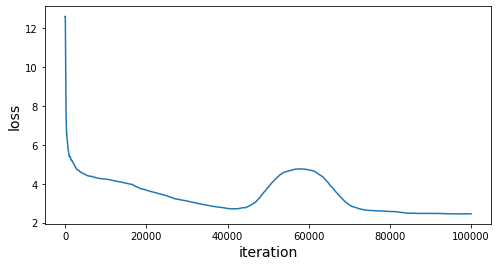

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(np.linspace(0, int(1e5), df_dqn[df_dqn.tag == 'Loss'].shape[0]), df_dqn[df_dqn.tag == 'Loss'].value)
plt.xlabel("iteration", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.savefig("../fig/dqn_loss_concept_drift.png")
plt.show()

We will see the accuracy evaluated in a prequential setting for later, when we compare it with that of Advantage Actor-Critic.

## Advantage Actor-Critic

Let's define the environment and the Advantage Actor-Critic agent.

In [10]:
env = EnvironmentDrift(generator, rewards_queries, encoder=encoder, r_plus=5, r_minus=-10, split_1=4, split_2=3)
agent = ActorCritic(categories=categories, min_queries=4)

In [4]:
agent.train(env, n_episodes=100000, lr=3e-4, lambd=1, max_step=30, log_dir='runs_drift_ac/', 
            path_save='drift_ac/', prequential=True)

Episode : 0
Episode : 1000
Episode : 2000
Episode : 3000
Episode : 4000
Episode : 5000
Episode : 6000
Episode : 7000
Episode : 8000
Episode : 9000
Episode : 10000
Episode : 11000
Episode : 12000
Episode : 13000
Episode : 14000
Episode : 15000
Episode : 16000
Episode : 17000
Episode : 18000
Episode : 19000
Episode : 20000
Episode : 21000
Episode : 22000
Episode : 23000
Episode : 24000
Episode : 25000
Episode : 26000
Episode : 27000
Episode : 28000
Episode : 29000
Episode : 30000
Episode : 31000
Episode : 32000
Episode : 33000
Episode : 34000
Episode : 35000
Episode : 36000
Episode : 37000
Episode : 38000
Episode : 39000
Episode : 40000
Episode : 41000
Episode : 42000
Episode : 43000
Episode : 44000
Episode : 45000
Episode : 46000
Episode : 47000
Episode : 48000
Episode : 49000
Episode : 50000
Episode : 51000
Episode : 52000
Episode : 53000
Episode : 54000
Episode : 55000
Episode : 56000
Episode : 57000
Episode : 58000
Episode : 59000
Episode : 60000
Episode : 61000
Episode : 62000
Episo

In [17]:
experiment_id = "aUxo7oCBTmyHwGKGMBnLFA"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df_ac = experiment.get_scalars()

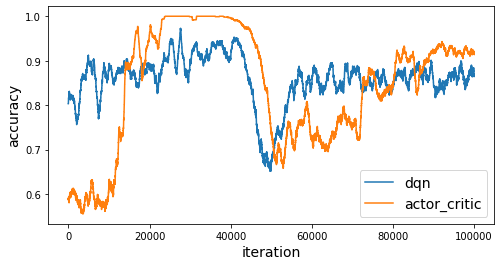

In [14]:
plt.figure(figsize=(8, 4))
plt.plot(np.linspace(0, int(1e5), df_ac[df_ac.tag == 'Episode/accuracy'].shape[0]), df_dqn[df_dqn.tag == 'accuracy'].value, label='dqn')
plt.plot(np.linspace(0, int(1e5), df_ac[df_ac.tag == 'Episode/accuracy'].shape[0]), df_ac[df_ac.tag == 'Episode/accuracy'].value, label='actor_critic')
plt.legend(fontsize=14)
plt.xlabel("iteration", fontsize=14)
plt.ylabel("accuracy", fontsize=14)
# plt.savefig('../fig/concept_drift.png')
plt.show()

In [4]:
class StreamGenerator(Stream):
    
    episode = 0
    
    def __init__(self, random_state=None, categories=[3, 5, 3, 3, 3, 5, 3, 5, 3, 3, 4, 3, 3, 3, 5], labels=[0, 1], split_1=4, split_2=4):
        
        super().__init__()
        
        self.random_state = random_state
        self._random_state = None  # This is the actual random_state object used internally
        self.categories = categories
        self.n_cat_features = len(categories)
        self.generator = dict([(i, np.full(categories[i], 1/categories[i])) for i in range(len(categories))])
        self.n_targets = 1
        self.split_1 = split_1
        self.split_2 = split_2
        self.n_classes = len(labels)
        self.n_features = self.n_cat_features
        self.name = "Generator"
        self.feature_names = ["att_num_" + str(i) for i in range(self.n_features)]
        self.target_names = ["target_0"]
        self.target_values = [i for i in range(self.n_classes)]
        self._prepare_for_use()
        
    def _prepare_for_use(self):
        
        self._random_state = check_random_state(self.random_state)
            
    def concept_1(self, data_point):
        """
        Description
        --------------
        Define the first labeling concept.
        
        Parameters
        --------------
        data_point : List of length d, the data point to label.
        
        Returns
        --------------
        Int in {0, 1}, the label of the data point.
        """
        
        label = True
        i = 0
        while label and i <= self.n_features-1:
            if data_point[i] >= self.split_1:
                label = False
                
            i += 1
            
        return label
    
    def concept_2(self, data_point):
        """
        Description
        --------------
        Define the second labeling concept.
        
        Parameters
        --------------
        data_point : List of length d, the data point to label.
        
        Returns
        --------------
        Int in {0, 1}, the label of the data point.
        """
        
        label = True
        i = 0
        while label and i <= self.n_features-1:
            if data_point[i] == self.split_2:
                label = False
                
            i += 1
            
        return label

    def next_sample(self, batch_size=1):
           
        data_point = [np.random.choice(self.categories[i], p=self.generator[i]) for i in range(self.n_features)]
        b = np.random.binomial(1, 1/(1 + np.exp(-(self.episode - 5e4)/2e3)))
        if b == 0:
            label = self.concept_1(data_point)
            
        else:
            label = self.concept_2(data_point)
            
        StreamGenerator.episode += 1
        self.current_sample_x, self.current_sample_y = np.array([data_point]), np.array([int(label)])
        return self.current_sample_x, self.current_sample_y
        
        

In [5]:
stream = StreamGenerator(categories=categories, split_1=4, split_2=3)

In [6]:
ht = HoeffdingTreeClassifier()

In [7]:
accuracies_deque = deque(maxlen = 1000)
accuracies_list = []
for i in range(100000):
    current_sample_x, current_sample_y = stream.next_sample()
    label_pred = ht.predict(current_sample_x)
    accuracies_deque.append(label_pred[0] == current_sample_y[0])
    ht.fit(current_sample_x, current_sample_y)
    if len(accuracies_deque) == 1000:
        accuracies_list.append(np.mean(accuracies_deque))
        
    if i%1000 == 0:
        print('iteration: %d' %i)

iteration: 0
iteration: 1000
iteration: 2000
iteration: 3000
iteration: 4000
iteration: 5000
iteration: 6000
iteration: 7000
iteration: 8000
iteration: 9000
iteration: 10000
iteration: 11000
iteration: 12000
iteration: 13000
iteration: 14000
iteration: 15000
iteration: 16000
iteration: 17000
iteration: 18000
iteration: 19000
iteration: 20000
iteration: 21000
iteration: 22000
iteration: 23000
iteration: 24000
iteration: 25000
iteration: 26000
iteration: 27000
iteration: 28000
iteration: 29000
iteration: 30000
iteration: 31000
iteration: 32000
iteration: 33000
iteration: 34000
iteration: 35000
iteration: 36000
iteration: 37000
iteration: 38000
iteration: 39000
iteration: 40000
iteration: 41000
iteration: 42000
iteration: 43000
iteration: 44000
iteration: 45000
iteration: 46000
iteration: 47000
iteration: 48000
iteration: 49000
iteration: 50000
iteration: 51000
iteration: 52000
iteration: 53000
iteration: 54000
iteration: 55000
iteration: 56000
iteration: 57000
iteration: 58000
iteration:

/home/otmane/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  
/home/otmane/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


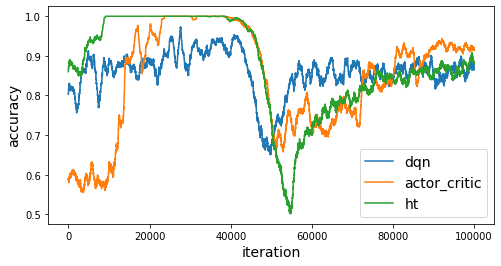

In [19]:
plt.figure(figsize=(8, 4))
plt.plot(np.linspace(0, int(1e5), df_ac[df_ac.tag == 'Episode/accuracy'].shape[0]), df_dqn[df_dqn.tag == 'accuracy'].value, label='dqn')
plt.plot(np.linspace(0, int(1e5), df_ac[df_ac.tag == 'Episode/accuracy'].shape[0]), df_ac[df_ac.tag == 'Episode/accuracy'].value, label='actor_critic')
plt.plot(np.linspace(0, int(1e5), df_ac[df_ac.tag == 'Episode/accuracy'].shape[0]), accuracies_list, label='ht')
plt.legend(fontsize=14)
plt.xlabel("iteration", fontsize=14)
plt.ylabel("accuracy", fontsize=14)
plt.savefig('../fig/concept_drift.png')
plt.show()